In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from parse import parse
import cv2

In [3]:
train_images, train_labels = parse('digitdata/trainingimages', 'digitdata/traininglabels', True)
validation_images, validation_labels = parse('digitdata/validationimages', 'digitdata/validationlabels', True)
test_images, test_labels = parse('digitdata/testimages', 'digitdata/testlabels', True)

In [4]:
base_rates = np.bincount(train_labels)/train_labels.shape[0]
print(base_rates)

[0.0958 0.1126 0.0976 0.0986 0.107  0.0868 0.1002 0.11   0.0924 0.099 ]


In [5]:
kernel = np.ones((3,1))
images = np.swapaxes(np.swapaxes(train_images.astype(np.float64), 0, 2), 0, 1)
dst = cv2.filter2D(src = images[:,:,0:512], ddepth = -1, kernel = kernel, anchor = (0, 0))
zones = dst[::3,::3,:]

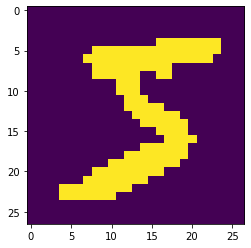

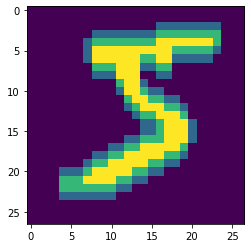

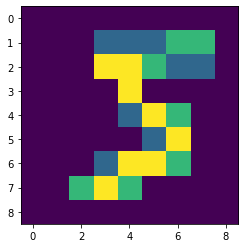

In [6]:
a = 0
plt.imshow(train_images[a,:,:])
plt.show()
plt.imshow(dst[:,:,a])
plt.show()
plt.imshow(zones[:,:,a])

In [7]:
def get_feature_probs(images = train_images, labels = train_labels, dim = (3,3), stride = -1, kernel = -1):

    labels = labels.astype(int)

    if stride == -1:
        stride = dim

    if kernel == -1:
        kernel = np.ones(dim)

    pixel_quant = dim[0]*dim[1] + 1

    kernel = np.ones(dim)
    images = np.swapaxes(np.swapaxes(images.astype(np.float64), 0, 2), 0, 1)

    dst = np.zeros_like(images)

    if images.shape[2] > 512:
        for i in range(int(np.ceil(images.shape[2]/512))):
            dst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = images[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
    else:
        dst= cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

    zones = dst.astype(int)[::stride[0],::stride[1],:].astype(int)
    zones = np.reshape(zones, (zones.shape[0]*zones.shape[1], zones.shape[2]))

    zone_probs = np.zeros((zones.shape[0], pixel_quant, base_rates.shape[0]))

    for i, zone in enumerate(zones):
        for number in range(0, base_rates.shape[0]):

            quant = np.bincount(zone[labels == number])

            quant = np.pad(quant, (0, pixel_quant - quant.shape[0]), constant_values = 0)

            if np.max(quant) != 0:
                zone_probs[i, :, number] = quant/np.sum(quant)

        zeros = zone_probs == 0
        zone_probs[zeros] = 0.000001

    return zone_probs

In [8]:
def get_features(images = train_images, dim = (3,3), stride = -1, kernel = -1):
    if stride == -1:
        stride = dim

    if kernel == -1:
        kernel = np.ones(dim)

    kernel = np.ones(dim)
    images = np.swapaxes(np.swapaxes(images.astype(np.float64), 0, 2), 0, 1)

    dst = np.zeros_like(images)

    if images.shape[2] > 512:
        for i in range(int(np.ceil(images.shape[2]/512))):
            dst[:, :, i*512:(i+1)*512] = cv2.filter2D(src = images[:, :, i*512:(i+1)*512], ddepth = -1, kernel = kernel, anchor = (0,0))
    else:
        dst= cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))

    zones = dst[::stride[0],::stride[1],:].astype(int)
    zones = np.reshape(zones, (zones.shape[0]*zones.shape[1], zones.shape[2]))

    return zones

In [9]:
def predict(train_images = train_images, train_labels = train_labels, val_images = validation_images, val_labels = validation_labels):
    dim = (3,1)

    base_rates = np.bincount(train_labels)/train_labels.shape[0]

    feature_probs = get_feature_probs(train_images, train_labels, dim, )
    train_features = get_features(train_images, dim)
    val_features = get_features(val_images, dim)

    train_image_probs = np.product(feature_probs[np.arange(len(train_features))[:, np.newaxis], train_features], axis = 0)
    train_preds = np.argmax(train_image_probs*base_rates, axis = 1)
    train_acc = np.sum(train_preds == train_labels)/train_labels.shape[0]

    val_image_probs = np.product(feature_probs[np.arange(len(val_features))[:, np.newaxis], val_features], axis = 0)
    val_preds = np.argmax(val_image_probs* base_rates, axis = 1)
    val_acc = np.sum(val_preds == val_labels)/val_labels.shape[0]

    return train_acc, val_acc


In [10]:
def main(train_images = train_images, train_labels = train_labels, test_images = validation_images, test_labels = validation_labels):
    dim = (3,1)

    base_rates = np.bincount(train_labels)/train_labels.shape[0]

    t_begin = time.time()
    feature_probs = get_feature_probs(train_images, train_labels, dim, )
    t_end = time.time() - t_begin

    train_features = get_features(train_images, dim)
    test_features = get_features(test_images, dim)

    train_image_probs = np.product(feature_probs[np.arange(len(train_features))[:, np.newaxis], train_features], axis = 0)
    train_preds = np.argmax(train_image_probs*base_rates, axis = 1)
    train_acc = np.sum(train_preds == train_labels)/train_labels.shape[0]

    test_image_probs = np.product(feature_probs[np.arange(len(test_features))[:, np.newaxis], test_features], axis = 0)
    test_preds = np.argmax(test_image_probs* base_rates, axis = 1)
    test_acc = np.sum(test_preds == test_labels)/test_labels.shape[0]

    return feature_probs, train_acc, test_acc, t_end

In [11]:
mean_acc = np.zeros((10, 2), dtype= np.float64)
std = np.zeros((10, 2), dtype= np.float64)
time_func = np.zeros((10, 1), dtype = np.float64)
models = []
iterations = 12

for i in range(1, 11):
    accuracy = np.zeros((iterations, 2), dtype= np.float64)
    avg_time = np.zeros((iterations, 1), dtype= np.float64)

    for iteration in range(0, iterations):

        ammount = int(0.1 * i * train_images.shape[0] )
        available_indices = np.random.choice(train_images.shape[0], ammount, replace = False)
        available_images = train_images[available_indices]
        available_labels = train_labels[available_indices]

        model, train_acc, test_acc, t = main(available_images, available_labels, test_images, test_labels)
        accuracy[iteration] = train_acc, test_acc
        avg_time[iteration] = t

        if i == 10:
            models.append(model)

    mean_acc[i-1] = np.mean(accuracy, axis = 0)
    std[i-1] = np.std(accuracy, axis = 0)
    time_func[i-1] = np.mean(avg_time)

In [12]:
print(f"Average results with all training data over {iterations} runs")
print("Accuracy: Train = {:.4f}, Test = {:.4f}".format(mean_acc[-1,0], mean_acc[-1,1]))
print("StD: Train = {:.1f}, Test = {:.1f}; should be 0".format(std[-1,0], std[-1,1]))
print("Runtime = {:.3f} seconds".format(time_func[-1][0]))

Average results with all training data over 12 runs
Accuracy: Train = 0.8728, Test = 0.8030
StD: Train = 0.0, Test = 0.0; should be 0
Runtime = 0.222 seconds


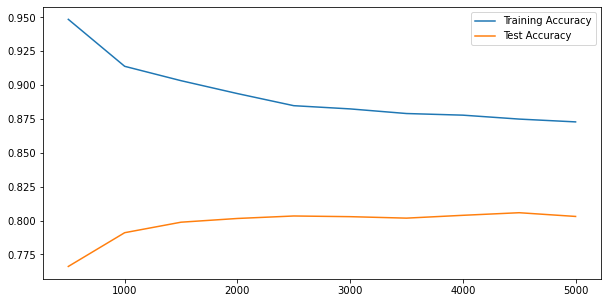

In [13]:
plt.figure(figsize = (10, 5))
x = np.linspace(.1*train_images.shape[0], train_images.shape[0], 10)
plt.plot(x, mean_acc[:,0], label = "Training Accuracy")
plt.plot(x, mean_acc[:,1], label = "Test Accuracy")
plt.legend()

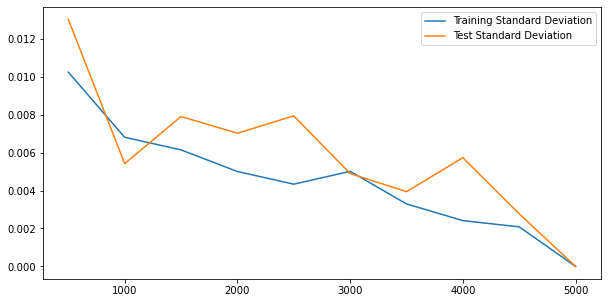

In [14]:
plt.figure(figsize = (10, 5))
x = np.linspace(.1*train_images.shape[0], train_images.shape[0], 10)
plt.plot(x, std[:,0], label = "Training Standard Deviation")
plt.plot(x, std[:,1], label = "Test Standard Deviation")
plt.legend()

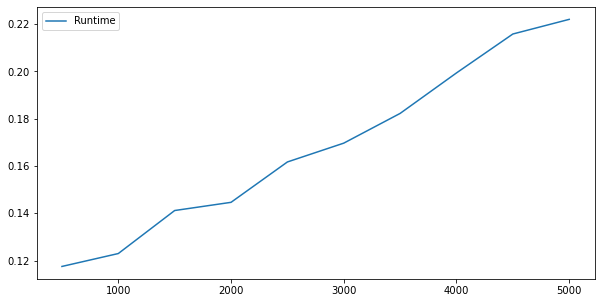

In [15]:
plt.figure(figsize = (10, 5))
x = np.linspace(.1*train_images.shape[0], train_images.shape[0], 10)
plt.plot(x, time_func, label = "Runtime")
plt.legend()